## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusions](#conclusions)
- [Part V - Resources](#source)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# no of rows
df.shape[0]

294478

In [4]:
# no of unique users in the dataset
df['user_id'].nunique()

290584

In [5]:
# To investigate if there are any duplicate rows
df.duplicated().value_counts()


False    294478
dtype: int64

**It seems that there are no duplicate rows, but there are repeated users.**

In [6]:
#The proportion of users converted.
df.converted.mean()

0.11965919355605512

In [7]:
#The number of times the `new_page` and `treatment` don't line up.
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [8]:
df.count()

user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64

**No missing values in any of the rows**

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

In [9]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) & ((df['group'] == 'control') == (df['landing_page'] == 'old_page'))]

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
# Count of unique **user_id**s in **df2**?
df2['user_id'].nunique()

290584

In [12]:
df2.shape[0]

290585

### There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# To have a look on the repeat user
df2[df2.duplicated(subset='user_id', keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### The row information for the repeat **user_id** 

**Its user_id is 773192, of group 'treatment', and landing_page is 'new_page'.**

In [14]:
# remove one of the rows with a duplicate user_id
df2 = df2.drop_duplicates(subset='user_id')

In [15]:
# to insure the removal of one of the repeated user_id
df2.shape[0]

290584

### What is the probability of an individual converting regardless of the page they receive?

In [16]:
# cr stands for conversion rate
cr = df2['converted'].mean()
cr

0.11959708724499628

### p<sub>population</sub> = cr 

### Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
cr_control = df2.query('group == "control"').converted.mean()
cr_control

0.1203863045004612

### Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
cr_treatment = df2.query('group == "treatment"').converted.mean()
cr_treatment

0.11880806551510564

In [19]:
# The actual difference in the conversion rates between the two groups.
obs_diff = cr_treatment - cr_control
obs_diff

-0.0015782389853555567

###  What is the probability that an individual received the new page?

In [20]:
# to calculate probability of each element in a column
df2['landing_page'].value_counts(normalize=True) 

new_page    0.500062
old_page    0.499938
Name: landing_page, dtype: float64

In [21]:
# another method
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

**We need to further investigate if the observed difference between conversions in new & old pages is statistically & practically significant.**

<a id='ab_test'></a>
### Part II - A/B Test


If we will make a decision just based on all the data provided.  If we assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, The Null & Alternative hypothesis would be as following:

$H_0$ : $p_{new}$ - $p_{old}$ ≤  0 <br><br>
$H_1$ :  $p_{new}$ - $p_{old}$ > 0 <br><br> 

Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we will assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Using a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


The **convert rate** for $p_{new}$ under the null: 

In [22]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

The **convert rate** for $p_{old}$ under the null:<br><br>

In [23]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [24]:
# n_new is the no of individuals in the treatment group.
df_new = df2.query('group == "treatment"')
n_new = df_new.shape[0]
n_new

145310

In [25]:
# n_old is the no of individuals in the control group.
df_old = df2.query('group == "control"')
n_old = df_old.shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
#new_page_converted = np.random.choice(2, size=n_new, p=[(1-p_new), p_new])
#new_page_converted.mean()



Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
#old_page_converted = np.random.choice(2, n_old, p=[(1-p_old), p_old])
#old_page_converted.mean()


$p_{new}$ - $p_{old}$ for simulated values.

In [28]:
# 𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  for simulated values:
#new_page_converted.mean() - old_page_converted.mean()

Simulating 10,000 $p_{new}$ - $p_{old}$ values.
Storing all 10,000 values in a numpy array called **p_diffs**.

In [29]:
# np.random.binomial(n_new,p_new,10000) is 10000
# simulations of the NUMBER of
# successes from n_new trials with prob p_new
# we want the PROPORTION, so we divide by n_new
new_page_converted_mean = np.random.binomial(n_new,p_new,10000)/n_new

old_page_converted_mean = np.random.binomial(n_old,p_old,10000)/n_old

p_diffs = new_page_converted_mean - old_page_converted_mean 
p_diffs

array([ 0.00176659,  0.00036303, -0.00139926, ...,  0.00100954,
        0.00115433,  0.00273016])

In [30]:
# convert list to array.
#p_diffs = np.array(p_diffs)

Plot a histogram of the **p_diffs**.

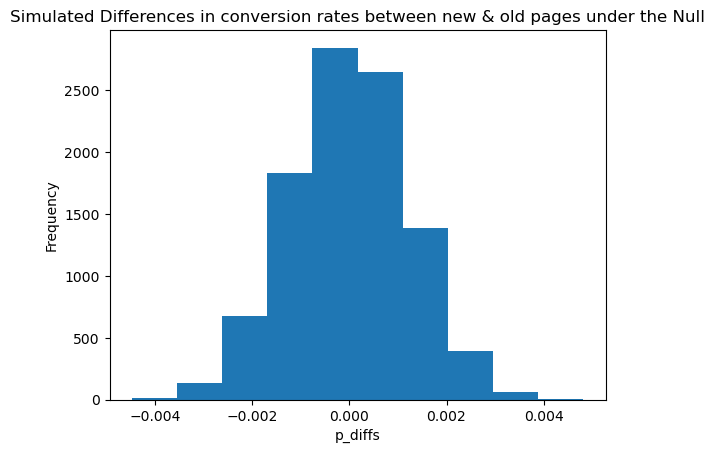

In [31]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Differences in conversion rates between new & old pages under the Null');

 **The mean of p_diffs is 0 meaning that there is no difference in conversion between old & new pages.**

The proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**

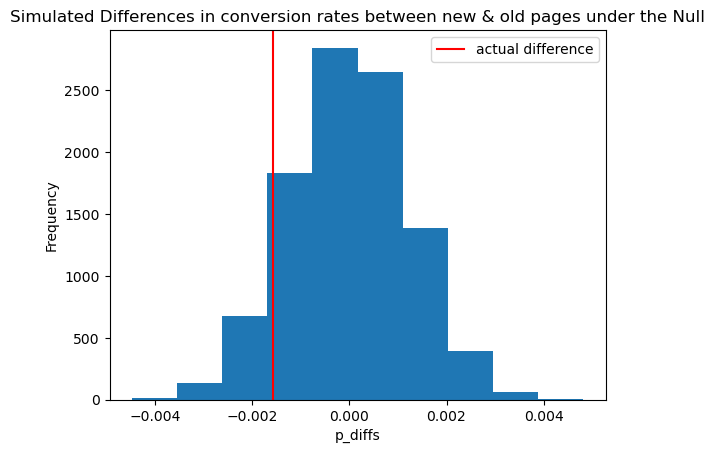

In [32]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Differences in conversion rates between new & old pages under the Null')
plt.axvline(obs_diff, color='r', label="actual difference")
plt.legend()
plt.show();

In [33]:
# the proportion of p_diffs greater than observed difference in ab_data.csv
p_value = (p_diffs > obs_diff).mean()
p_value

0.9024

**p_value is greater than the type 1 error rate of 0.05 meaning that there is a high probability that our data is consistent with the null hypothesis.**<br><br>

**Result: fail to reject null hypothesis.** <br><br>

Using a built-in to achieve similar results.  

In [34]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

convert_old = df_old.query('converted == 1').shape[0]
convert_new = df_new.query('converted == 1').shape[0]
n_old = df_old.shape[0]  
n_new = df_new.shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

Using `stats.proportions_ztest` to compute the test statistic and p-value.

In [35]:
z_score, p_val = proportions_ztest(np.array([convert_new, convert_old]), np.array([n_new, n_old]), alternative='larger')
z_score,p_val

(-1.3109241984234394, 0.9050583127590245)

**The p-value is greater than 0.05 (type I error rate) meaning fail to reject the null hypothesis and there is no significant difference between conversion rates of old & new pages.**<br><br>
**z_score < $Z_{\alpha}$ so it doesn't lie in the rejection region, and we can't reject the null hypothesis.**<br><br>
**this result agrees with the previous findings.**<br><br>

<a id='regression'></a>
### Part III - A regression approach

Acheivement of the same results of the previous A/B test by performing Logestic Regression.<br><br>

In [36]:
# create a dummy variable column for which page each user received 
#(an ab_page column), which is 1 when an individual receives the treatment and 0 if control.
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']

In [37]:
# Add an intercept column
df2['intercept'] = 1
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])


Using **statsmodels** to import regression model.  Instantiate the model, and fit the model using the two created columns
to predict whether or not an individual converts.

In [38]:
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-12-10 13:57 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**The p-value associated with ab_page is 0.1899, which is different from p-value found in part II, this is because the alternative hypothesis of regression models is that difference ≠ 0. i.e. two-sided hypothesis , while in part II the alternative was difference > 0 (one-sided hypothesis), however both are greater than α indicating that there is no significant evidence to reject the null hypothesis.**

In [39]:
# to investigate the impact of the country that the user lives in, on the conversion
countries_df = pd.read_csv('./countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
# according to the documentation, joining 2 dataframes using 'user_id' as an index.
new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [41]:
new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [42]:
# to study the impact of country on the rate of conversion.
new.groupby('country').converted.mean()

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

In [43]:
# previously found data
cr_control, cr_treatment, cr

(0.1203863045004612, 0.11880806551510564, 0.11959708724499628)

**It seems that there is no impact of the country on the conversion rate as all countries have close conversion rates, also conversion rates associated with countries are similar to that associated with a landing page (cr_control, cr_treatment) previously found and similar to the conversion rate of the dataset df2(cr).**

In [44]:
# Create the necessary dummy variables
new[['US', 'UK', 'CA']] = pd.get_dummies(new['country'])
new = new.drop('CA', axis=1)
# the third option is known by intuition

In [45]:
logit_mod = sm.Logit(new['converted'], new[['intercept','ab_page', 'US', 'UK']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-12-10 13:57 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

**It's obvious that all p_values for page type & countries are greater than type I error rate (0.05), this means that there is no impact of the page type or the country on the rate of conversions and there is a high probability that our data is consistent with the null hypothesis.**

In [46]:
# To investigate the impact of the page & the country altogether on the conversion.
# fitting regression model & summarize the results.
new['US_inter'] = new['US']*new['ab_page']
new['UK_inter'] = new['UK']*new['ab_page']
logit_mod = sm.Logit(new['converted'], new[['intercept','ab_page', 'US', 'UK', 'US_inter', 'UK_inter']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-12-10 13:57 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
US           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
US_inter     -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_inter      0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

**In the last model I investigate the interactions between each country & the page type obviously, the p_values for interactions are greater than 0.05, and there is no effect on conversion.**

<a id='conclusions'></a>
## Part IV - Conclusions
**The goal of the analysis is to compare a newly developed web page with the old one concerning the rate of conversion, so I investigated our dataset in three different approaches, simulating the sampling distribution, using Z-test, and using a logit model. also studied the effect of other factors which may cause bias like the country of the user.** <br><br>
**All methods came to the same result that is we failed to reject the null hypothesis, we haven't enough evidence that the new page is better than the old page, and I recommend that the company develops another page.**

<a id='source'></a>
### Part IV - Resources

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html <br><br>
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html <br><br>
https://www.statology.org/two-proportion-z-test/